Wczytaj zbiór `Carseats.csv`. Usuń kolumnę `Sales` i zastąp ją zmienną kategoryczną `SalesHigh`, która przyjmie wartość `Yes`, jeśli `Sales >= 8` i `No` w przeciwnym przypadku. Użyj drzew decyzyjnych do predykcji wartości `SalesHigh` na podstawie pozostałych zmiennych.
- Podziel dane na zbiór treningowy i testowy. Ze zbioru treningowego wydziel dodatkowo zbiór walidacyjny lub stosuj walidację krzyżową.
- Stwórz model [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 
- Zmniejsz rozmiar drzewa stosując 'przycinanie' (pruning). Wygeneruj wartości `ccp_alpha` metodą `cost_complexity_pruning_path()`. Użyj zbioru walidacyjnego lub walidacji krzyżowej (np. [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) aby znaleźć najlepszą wartość. Zobacz, jak to zrobić w dokumentacji: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
- Porównaj modele przed i po przycinaniu. Jak wpłynęło na jakość predykcji? Jak zmienił się rozmiar drzewa (sprawdź metodami `get_depth()`, `get_n_leaves()`)?
- Sprawdź jaki wpływ na jakość predykcji ma regulowanie rozmiaru drzewa, np. parametrami `max_depth`, `max_leaf_nodes`. *-> to ma sens tylko wtedy kiedy nie zrobilismy parametru alpha (alpha tez powinno działać lepiej)*
- Stwórz model [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) i porównaj go z wcześniej tworzonymi modelami.
- Wybierz najlepsze ze stworzonych drzew decyzyjnych, biorąc pod uwagę zarówno jakość predykcji, jak i rozmiar drzewa. Wizualizuj drzewo metodą [`plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Dokonaj ewaluacji korzystając ze zbioru testowego.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier

In [44]:
df = pd.read_csv("../data/Carseats.csv")
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [45]:
df['SalesHigh'] = df['Sales'].apply(lambda x: "Yes" if x >= 8 else "No")
df = df.drop(columns=['Sales'])
df.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,SalesHigh
0,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
1,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
2,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
3,117,100,4,466,97,Medium,55,14,Yes,Yes,No
4,141,64,3,340,128,Bad,38,13,Yes,No,No


In [46]:
print(df.shape)
df.info()

(400, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CompPrice    400 non-null    int64 
 1   Income       400 non-null    int64 
 2   Advertising  400 non-null    int64 
 3   Population   400 non-null    int64 
 4   Price        400 non-null    int64 
 5   ShelveLoc    400 non-null    object
 6   Age          400 non-null    int64 
 7   Education    400 non-null    int64 
 8   Urban        400 non-null    object
 9   US           400 non-null    object
 10  SalesHigh    400 non-null    object
dtypes: int64(7), object(4)
memory usage: 34.5+ KB


In [47]:
categorical_columns = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [48]:
print(df.shape)
df.info()

(400, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CompPrice         400 non-null    int64
 1   Income            400 non-null    int64
 2   Advertising       400 non-null    int64
 3   Population        400 non-null    int64
 4   Price             400 non-null    int64
 5   Age               400 non-null    int64
 6   Education         400 non-null    int64
 7   ShelveLoc_Good    400 non-null    bool 
 8   ShelveLoc_Medium  400 non-null    bool 
 9   Urban_Yes         400 non-null    bool 
 10  US_Yes            400 non-null    bool 
 11  SalesHigh_Yes     400 non-null    bool 
dtypes: bool(5), int64(7)
memory usage: 24.0 KB


In [49]:
X = df.drop(columns=['SalesHigh_Yes'])
y = df['SalesHigh_Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

### Decision Tree Classifier

In [50]:
feature_names = X.columns.tolist()
# (SalesHigh_Yes: False to 'No', True to 'Yes')
class_names = ['No', 'Yes']

In [51]:
dtc = DecisionTreeClassifier(random_state=17)
dtc.fit(X_train, y_train)

# Evaluation on test dataset
# Overfitting - model remembers the training dataset
y_pred_train = dtc.predict(X_train)
print("Model before pruning - evaluation on train dataset:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Tree depth: {dtc.get_depth()}")
print(f"Amount of leaves: {dtc.get_n_leaves()}")

Model before pruning - evaluation on train dataset:
Accuracy: 1.0000
Tree depth: 9
Amount of leaves: 51


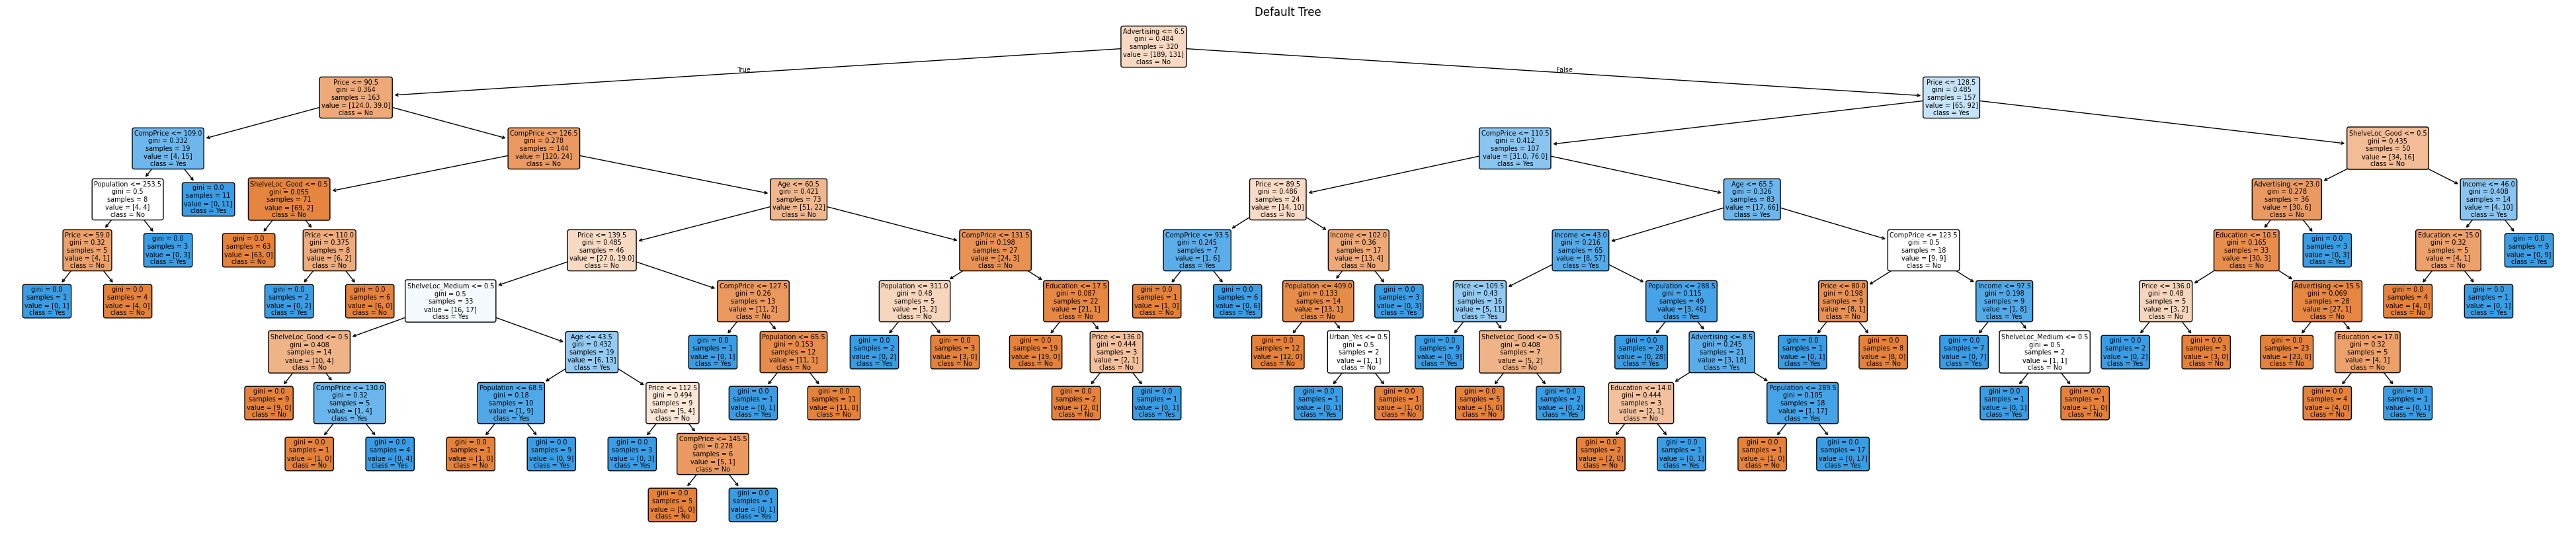

|--- Advertising <= 6.50
|   |--- Price <= 90.50
|   |   |--- CompPrice <= 109.00
|   |   |   |--- Population <= 253.50
|   |   |   |   |--- Price <= 59.00
|   |   |   |   |   |--- weights: [0.00, 1.00] class: True
|   |   |   |   |--- Price >  59.00
|   |   |   |   |   |--- weights: [4.00, 0.00] class: False
|   |   |   |--- Population >  253.50
|   |   |   |   |--- weights: [0.00, 3.00] class: True
|   |   |--- CompPrice >  109.00
|   |   |   |--- weights: [0.00, 11.00] class: True
|   |--- Price >  90.50
|   |   |--- CompPrice <= 126.50
|   |   |   |--- ShelveLoc_Good <= 0.50
|   |   |   |   |--- weights: [63.00, 0.00] class: False
|   |   |   |--- ShelveLoc_Good >  0.50
|   |   |   |   |--- Price <= 110.00
|   |   |   |   |   |--- weights: [0.00, 2.00] class: True
|   |   |   |   |--- Price >  110.00
|   |   |   |   |   |--- weights: [6.00, 0.00] class: False
|   |   |--- CompPrice >  126.50
|   |   |   |--- Age <= 60.50
|   |   |   |   |--- Price <= 139.50
|   |   |   |   |   |---

In [52]:
plt.figure(figsize=(50,10))
plot_tree(dtc,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Default Tree")
plt.show()

print(export_text(dtc, feature_names=feature_names, show_weights=True))

In [53]:
# Generating ccp_alpha
path = dtc.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Removing the maximum alpha value, which gives a trivial tree
ccp_alphas = ccp_alphas[:-1]

# Using GridSearchCV to find best ccp_alpha value
# GridSearchCV automatically uses cross-validation
param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_ccp_alpha = grid_search.best_params_['ccp_alpha']
# Model with the best ccp_alpha
dtc_pruned = grid_search.best_estimator_

print(f"Best ccp_alpha value found by GridSearchCV: {best_ccp_alpha:.4f}")

# Evaluation of the pruned tree on the training dataset
y_pred_train_pruned = dtc_pruned.predict(X_train)
print("\nPruned model (ccp_alpha) - train dataset evaluation:")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train_pruned):.4f}")
print(f"Tree depth: {dtc_pruned.get_depth()}")
print(f"Amount of leaves: {dtc_pruned.get_n_leaves()}")

Best ccp_alpha value found by GridSearchCV: 0.0097

Pruned model (ccp_alpha) - train dataset evaluation:
Accuracy: 0.8625
Tree depth: 5
Amount of leaves: 13


In [54]:
clfs_viz = []
train_scores_viz = []
test_scores_viz = []
node_counts_viz = []
depths_viz = []

for i, alpha_val in enumerate(ccp_alphas):
    # It cant be negative, so we ensure it's non-negative
    current_alpha_for_tree = max(0, alpha_val)

    clf_viz_alpha = DecisionTreeClassifier(random_state=17, ccp_alpha=current_alpha_for_tree)
    clf_viz_alpha.fit(X_train, y_train)

    clfs_viz.append(clf_viz_alpha)
    train_scores_viz.append(clf_viz_alpha.score(X_train, y_train))
    test_scores_viz.append(clf_viz_alpha.score(X_test, y_test))
    node_counts_viz.append(clf_viz_alpha.tree_.node_count)
    depths_viz.append(clf_viz_alpha.get_depth())

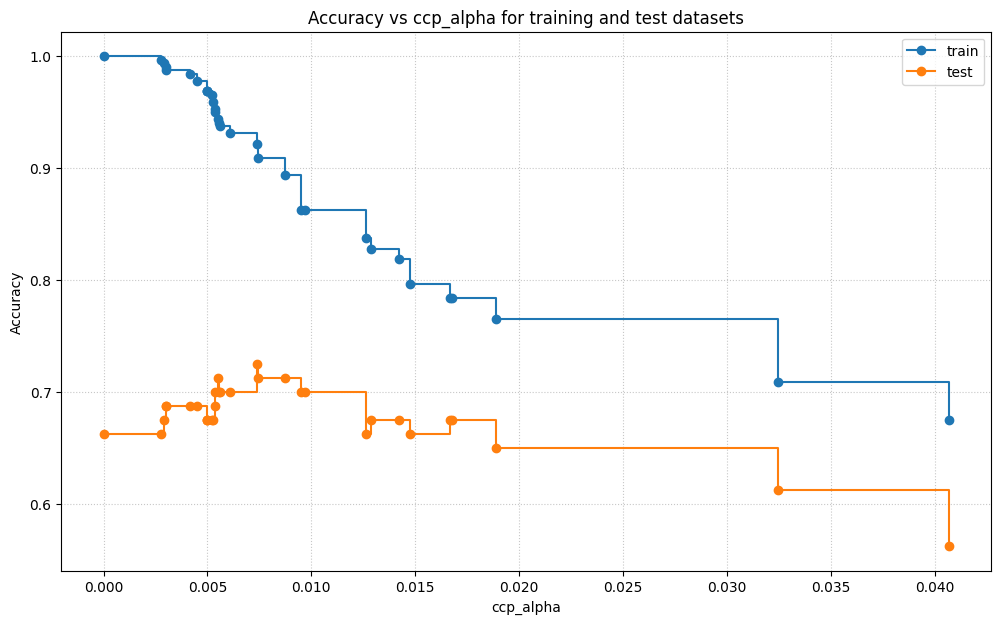

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs ccp_alpha for training and test datasets")
ax.plot(ccp_alphas, train_scores_viz, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_viz, marker='o', label="test", drawstyle="steps-post")

ax.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

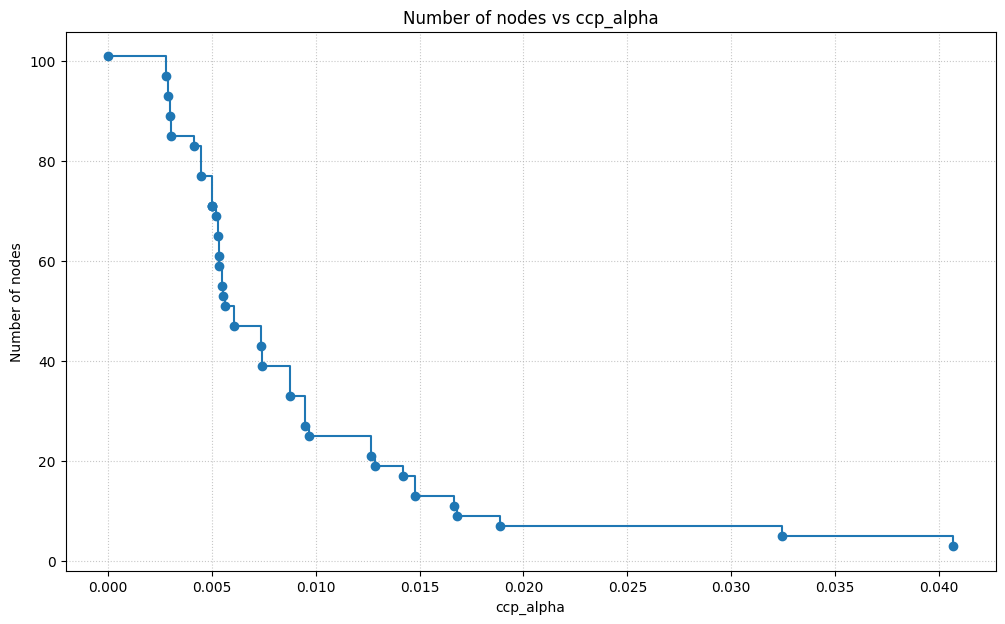

In [56]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ccp_alphas, node_counts_viz, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Number of nodes")
ax.set_title("Number of nodes vs ccp_alpha")

plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

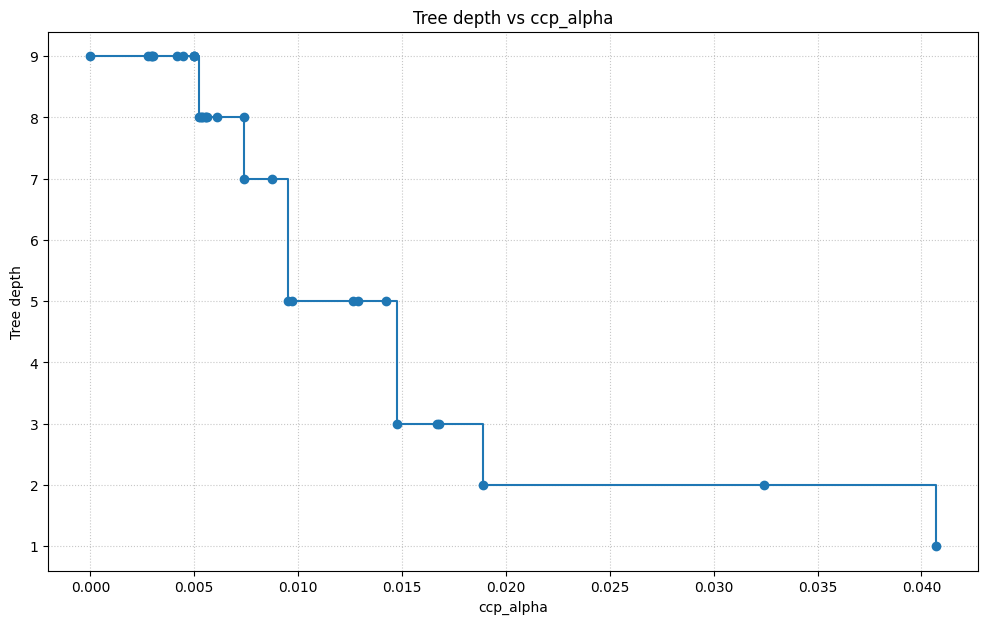

In [66]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(ccp_alphas, depths_viz, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Tree depth")
ax.set_title("Tree depth vs ccp_alpha")

plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

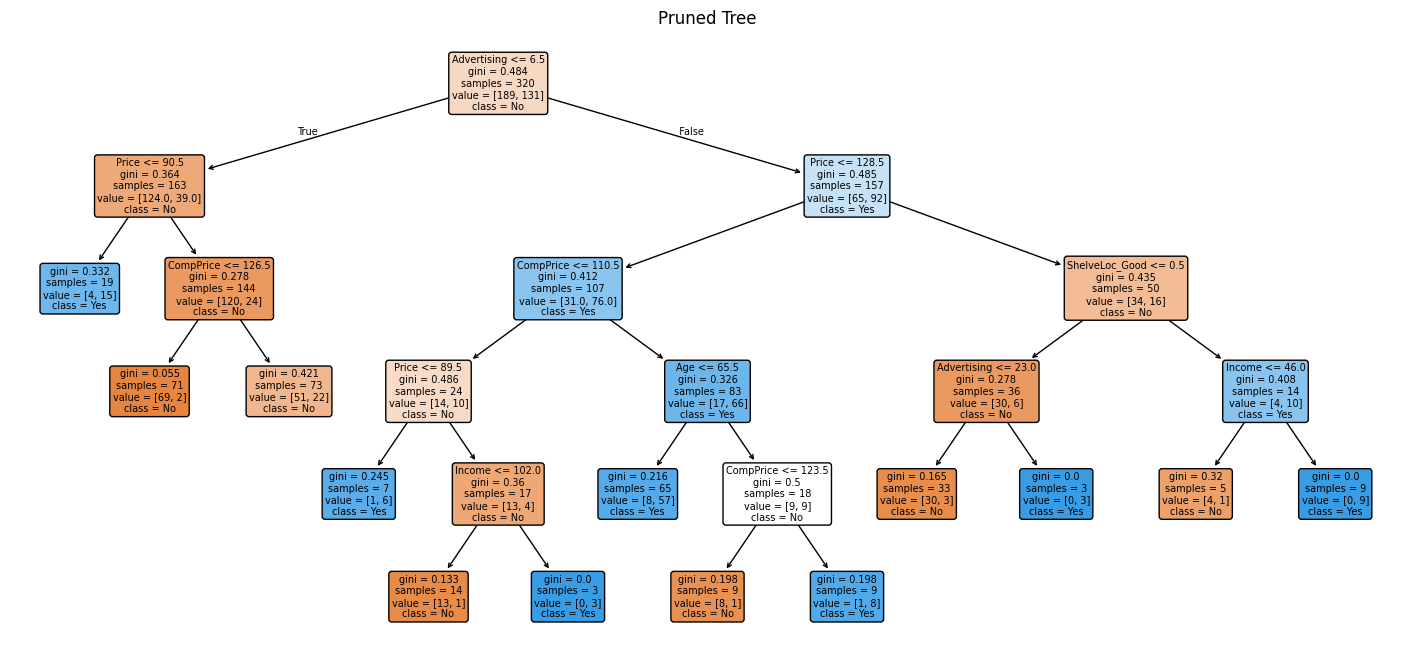

|--- Advertising <= 6.50
|   |--- Price <= 90.50
|   |   |--- weights: [4.00, 15.00] class: True
|   |--- Price >  90.50
|   |   |--- CompPrice <= 126.50
|   |   |   |--- weights: [69.00, 2.00] class: False
|   |   |--- CompPrice >  126.50
|   |   |   |--- weights: [51.00, 22.00] class: False
|--- Advertising >  6.50
|   |--- Price <= 128.50
|   |   |--- CompPrice <= 110.50
|   |   |   |--- Price <= 89.50
|   |   |   |   |--- weights: [1.00, 6.00] class: True
|   |   |   |--- Price >  89.50
|   |   |   |   |--- Income <= 102.00
|   |   |   |   |   |--- weights: [13.00, 1.00] class: False
|   |   |   |   |--- Income >  102.00
|   |   |   |   |   |--- weights: [0.00, 3.00] class: True
|   |   |--- CompPrice >  110.50
|   |   |   |--- Age <= 65.50
|   |   |   |   |--- weights: [8.00, 57.00] class: True
|   |   |   |--- Age >  65.50
|   |   |   |   |--- CompPrice <= 123.50
|   |   |   |   |   |--- weights: [8.00, 1.00] class: False
|   |   |   |   |--- CompPrice >  123.50
|   |   |   |   |

In [58]:
plt.figure(figsize=(18,8))
plot_tree(dtc_pruned,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Pruned Tree")
plt.show()

print(export_text(dtc_pruned, feature_names=feature_names, show_weights=True))

In [59]:
# Evaluation on the test dataset
y_pred_test_default = dtc.predict(X_test)
y_pred_test_pruned = dtc_pruned.predict(X_test)

print("\nEvaluation on test data:")
print(f"Default model: Accuracy={accuracy_score(y_test, y_pred_test_default):.4f}")
print(f"Pruned model: Accuracy={accuracy_score(y_test, y_pred_test_pruned):.4f}")


Evaluation on test data:
Default model: Accuracy=0.6625
Pruned model: Accuracy=0.7000


In [60]:
print("Impact of `max_depth` (pre-pruning):")
depths = [3, 5, 7, 10, None] # None means no limit
results_depth = []

for depth in depths:
    dtc_max_depth = DecisionTreeClassifier(max_depth=depth, random_state=17)
    
    # Cross-validation on training data
    cv_scores = cross_val_score(dtc_max_depth, X_train, y_train, cv=5, scoring='accuracy')
    results_depth.append(cv_scores.mean())
    print(f"max_depth={depth}: Mean accuracy cross-validation = {cv_scores.mean():.4f}")

best_depth_idx = np.argmax(results_depth)
best_max_depth = depths[best_depth_idx]
print(f"\nBest `max_depth` based on cross-validation: {best_max_depth}")

dtc_best_depth = DecisionTreeClassifier(max_depth=best_max_depth, random_state=17)
dtc_best_depth.fit(X_train, y_train)
y_pred_test_best_depth = dtc_best_depth.predict(X_test)
print(f"\nModel with max_depth={best_max_depth}: Accuracy on test={accuracy_score(y_test, y_pred_test_best_depth):.4f}, Tree depth={dtc_best_depth.get_depth()}, Amount of leaves={dtc_best_depth.get_n_leaves()}")

Impact of `max_depth` (pre-pruning):
max_depth=3: Mean accuracy cross-validation = 0.7344
max_depth=5: Mean accuracy cross-validation = 0.7375
max_depth=7: Mean accuracy cross-validation = 0.7688
max_depth=10: Mean accuracy cross-validation = 0.7562
max_depth=None: Mean accuracy cross-validation = 0.7562

Best `max_depth` based on cross-validation: 7

Model with max_depth=7: Accuracy on test=0.6875, Tree depth=7, Amount of leaves=45


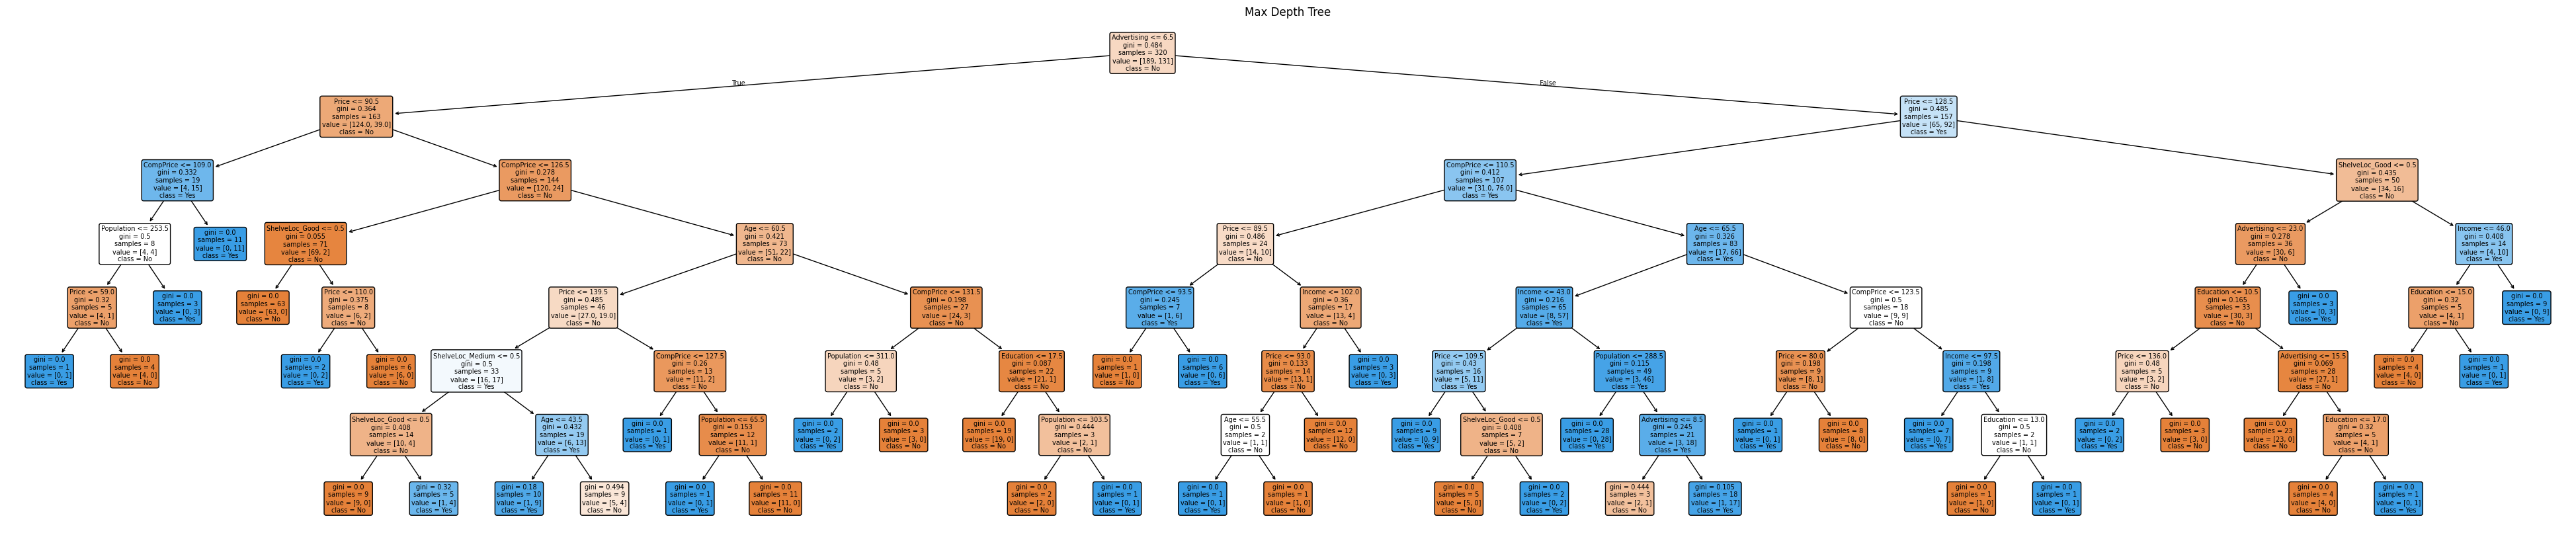

|--- Advertising <= 6.50
|   |--- Price <= 90.50
|   |   |--- CompPrice <= 109.00
|   |   |   |--- Population <= 253.50
|   |   |   |   |--- Price <= 59.00
|   |   |   |   |   |--- weights: [0.00, 1.00] class: True
|   |   |   |   |--- Price >  59.00
|   |   |   |   |   |--- weights: [4.00, 0.00] class: False
|   |   |   |--- Population >  253.50
|   |   |   |   |--- weights: [0.00, 3.00] class: True
|   |   |--- CompPrice >  109.00
|   |   |   |--- weights: [0.00, 11.00] class: True
|   |--- Price >  90.50
|   |   |--- CompPrice <= 126.50
|   |   |   |--- ShelveLoc_Good <= 0.50
|   |   |   |   |--- weights: [63.00, 0.00] class: False
|   |   |   |--- ShelveLoc_Good >  0.50
|   |   |   |   |--- Price <= 110.00
|   |   |   |   |   |--- weights: [0.00, 2.00] class: True
|   |   |   |   |--- Price >  110.00
|   |   |   |   |   |--- weights: [6.00, 0.00] class: False
|   |   |--- CompPrice >  126.50
|   |   |   |--- Age <= 60.50
|   |   |   |   |--- Price <= 139.50
|   |   |   |   |   |---

In [61]:
plt.figure(figsize=(50,10))
plot_tree(dtc_best_depth,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=7)
plt.title("Max Depth Tree")
plt.show()

print(export_text(dtc_best_depth, feature_names=feature_names, show_weights=True))

### Random Forest

In [62]:
rf = RandomForestClassifier(random_state=17, n_estimators=100)
rf.fit(X_train, y_train)

y_test_rf = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_test_rf):.4f}")
print(f"\n{classification_report(y_test, y_test_rf)}")

Accuracy: 0.8500

              precision    recall  f1-score   support

       False       0.83      0.94      0.88        47
        True       0.89      0.73      0.80        33

    accuracy                           0.85        80
   macro avg       0.86      0.83      0.84        80
weighted avg       0.85      0.85      0.85        80



### Evaluation

In [63]:
print(f"Default model: Accuracy={accuracy_score(y_test, y_pred_test_default):.4f}")
print(f"Pruned model: Accuracy={accuracy_score(y_test, y_pred_test_pruned):.4f}")
print(f"Best max_depth model: Accuracy={accuracy_score(y_test, y_pred_test_best_depth):.4f}")
print(f"Random Forest model: Accuracy={accuracy_score(y_test, y_test_rf):.4f}")

Default model: Accuracy=0.6625
Pruned model: Accuracy=0.7000
Best max_depth model: Accuracy=0.6875
Random Forest model: Accuracy=0.8500
